In [1]:
from superdebug import debug
from process_data import get_model_input
from train import evaluate_model, get_normalization_weights
from model import get_best_model, TransformerVoter
from utils import get_config, load_model, save_model, to_device, parse_config
import pandas as pd
import numpy as np
from collections import Counter
config = get_config("configs/subreddit_minority_no_peer_new.yml", "_test", print_config=False)
target, original_feature_map, categorical_features, string_features, train_data, test_data, test_data_info, train_submission_upvote_df, num_all_users = get_model_input(config)
model = TransformerVoter(config, categorical_features, string_features, original_feature_map)
extra_input = (categorical_features, string_features, target)

为了使用邮件提醒功能，请设置环境变量MY_QQ_EMAIL（QQ邮箱地址）与MY_QQ_EMAIL_PWD（QQ邮箱授权码）
------------------ 2022-09-01 05:42:51 ------------------


Version 7.5.0 of praw is outdated. Version 7.6.0 was released Tuesday May 10, 2022.


GPU ready...
Smart using cuda:1
------------------ 2022-09-01 05:43:01 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/process_data.py:363 get_model_input
Loading prepared data...
------------------ 2022-09-01 05:43:01 ------------------
------------------ 2022-09-01 05:43:06 ------------------
DEBUG: 1 vars: ['original_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:248 get_tokenizer
0 / 1.  original_token_num num val: 30522
------------------ 2022-09-01 05:43:06 ------------------
------------------ 2022-09-01 05:43:07 ------------------
DEBUG: 1 vars: ['latest_token_num'], at /home/TableSense/largedisk/wanrong/Curation-Modeling/model.py:260 get_tokenizer
0 / 2.  latest_token_num num val: 246905
------------------ 2022-09-01 05:43:07 ------------------


Some weights of the model checkpoint at prajjwal1/bert-mini were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.bias', 'cls.predictions.transform.LayerNorm.weight', 'cls.seq_relationship.bias', 'cls.predictions.decoder.weight', 'cls.predictions.decoder.bias', 'cls.seq_relationship.weight', 'cls.predictions.transform.dense.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [2]:
# test_data = test_data.iloc[:10]
# test_data_info = test_data_info.iloc[:10]
set(train_data["SUBREDDIT"])

{'r/Conservative',
 'r/Feminism',
 'r/Jokes',
 'r/LesbianActually',
 'r/Liberal',
 'r/MensRights',
 'r/Republican',
 'r/ScienceFacts',
 'r/Showerthoughts',
 'r/VoteBlue',
 'r/democrats',
 'r/gay',
 'r/politics',
 'r/science',
 'r/shittyaskscience',
 'r/technology',
 'r/teenagers',
 'r/trans'}

------------------ 2022-09-01 05:43:13 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/utils.py:113 load_model
Loading latest model...
------------------ 2022-09-01 05:43:13 ------------------


/home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:48: RuntimeWarning: divide by zero encountered in true_divide
  minority_weight = 1/data["same_vote_rate"].to_numpy()
100%|██████████| 6145/6145 [04:27<00:00, 22.98it/s]


------------------ 2022-09-01 05:48:49 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:257 evaluate_model
How well can the model deal with cold start problem?
------------------ 2022-09-01 05:48:49 ------------------
------------------ 2022-09-01 05:48:49 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:263 evaluate_model
Accuracy & confidence given different #votes on this post
------------------ 2022-09-01 05:48:49 ------------------


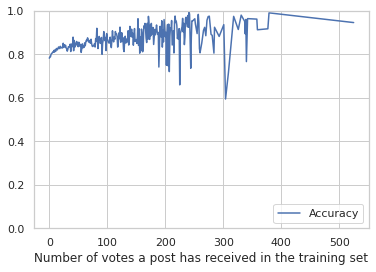

------------------ 2022-09-01 05:48:50 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:270 evaluate_model
How well can the model predict the lurkers' opinions?
------------------ 2022-09-01 05:48:50 ------------------
------------------ 2022-09-01 05:48:50 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:276 evaluate_model
Accuracy & confidence given different #votes from this user
------------------ 2022-09-01 05:48:50 ------------------


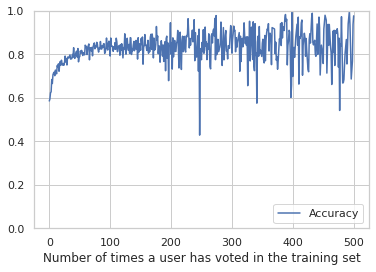

------------------ 2022-09-01 05:48:50 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:283 evaluate_model
How well can the model predict the minority opinions?
------------------ 2022-09-01 05:48:50 ------------------
------------------ 2022-09-01 05:48:50 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:289 evaluate_model
Accuracy & confidence given different %votes that is same as the target vote
------------------ 2022-09-01 05:48:50 ------------------


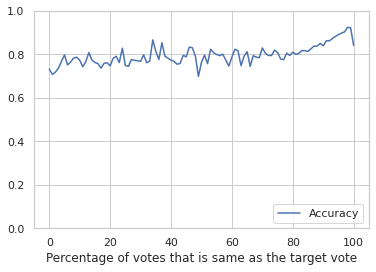

eval_all_test_data: - acc: 0.8202144324863182 - acc_vote_0: 0.8212637320720171 - acc_vote_1: 0.8198328478291025 - acc_train_user_votes_num>=3: 0.821574714085008 - acc_vote_0_train_user_votes_num>=3: 0.8230682123526928 - acc_vote_1_train_user_votes_num>=3: 0.8210316200154244 - acc_train_submission_votes_num>=3: 0.8372059796667268 - acc_vote_0_train_submission_votes_num>=3: 0.8186435364196886 - acc_vote_1_train_submission_votes_num>=3: 0.8412776277604838 - acc_train_user_votes_num<=3: 0.6112213091527345 - acc_vote_0_train_user_votes_num<=3: 0.5418410041841004 - acc_vote_1_train_user_votes_num<=3: 0.6369996113486203 - acc_train_submission_votes_num<=3: 0.7862928743197064 - acc_vote_0_train_submission_votes_num<=3: 0.8263762274893645 - acc_vote_1_train_submission_votes_num<=3: 0.7548436480449732 - acc_with_weight: nan - acc_vote_0_with_weight: nan - acc_vote_1_with_weight: nan - acc_train_user_votes_num>=3_with_weight: nan - acc_vote_0_train_user_votes_num>=3_with_weight: nan - acc_vote_1_

/home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:48: RuntimeWarning: divide by zero encountered in true_divide
  minority_weight = 1/data["same_vote_rate"].to_numpy()
100%|██████████| 6145/6145 [04:25<00:00, 23.19it/s]


------------------ 2022-09-01 05:54:23 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:257 evaluate_model
How well can the model deal with cold start problem?
------------------ 2022-09-01 05:54:23 ------------------
------------------ 2022-09-01 05:54:23 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:263 evaluate_model
Accuracy & confidence given different #votes on this post
------------------ 2022-09-01 05:54:23 ------------------


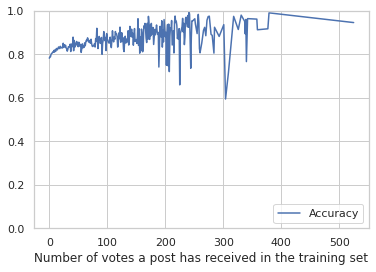

------------------ 2022-09-01 05:54:23 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:270 evaluate_model
How well can the model predict the lurkers' opinions?
------------------ 2022-09-01 05:54:23 ------------------
------------------ 2022-09-01 05:54:23 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:276 evaluate_model
Accuracy & confidence given different #votes from this user
------------------ 2022-09-01 05:54:23 ------------------


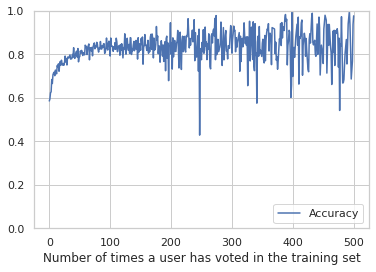

------------------ 2022-09-01 05:54:24 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:283 evaluate_model
How well can the model predict the minority opinions?
------------------ 2022-09-01 05:54:24 ------------------
------------------ 2022-09-01 05:54:24 ------------------
DEBUG: at /home/TableSense/largedisk/wanrong/Curation-Modeling/train.py:289 evaluate_model
Accuracy & confidence given different %votes that is same as the target vote
------------------ 2022-09-01 05:54:24 ------------------


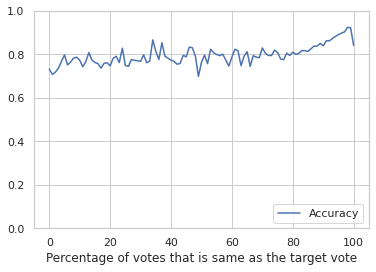

eval_all_test_data: - acc: 0.8202144324863182 - acc_vote_0: 0.8212637320720171 - acc_vote_1: 0.8198328478291025 - acc_train_user_votes_num>=3: 0.821574714085008 - acc_vote_0_train_user_votes_num>=3: 0.8230682123526928 - acc_vote_1_train_user_votes_num>=3: 0.8210316200154244 - acc_train_submission_votes_num>=3: 0.8372059796667268 - acc_vote_0_train_submission_votes_num>=3: 0.8186435364196886 - acc_vote_1_train_submission_votes_num>=3: 0.8412776277604838 - acc_train_user_votes_num<=3: 0.6112213091527345 - acc_vote_0_train_user_votes_num<=3: 0.5418410041841004 - acc_vote_1_train_user_votes_num<=3: 0.6369996113486203 - acc_train_submission_votes_num<=3: 0.7862928743197064 - acc_vote_0_train_submission_votes_num<=3: 0.8263762274893645 - acc_vote_1_train_submission_votes_num<=3: 0.7548436480449732 - acc_with_weight: nan - acc_vote_0_with_weight: nan - acc_vote_1_with_weight: nan - acc_train_user_votes_num>=3_with_weight: nan - acc_vote_0_train_user_votes_num>=3_with_weight: nan - acc_vote_1_

In [3]:
model_types = ["latest", "best"]
for model_type in model_types:
    model, _, _, _, _ = load_model(config["save_model_dir"], model, model.optim, 0, 0, model_type)
    model.to(model.device)
    test_weights = get_normalization_weights(test_data, train_submission_upvote_df, config)
    if config["use_voted_users_feature"]:
        debug("Use all voted users as feature")
    eval_all_test_data = evaluate_model(config, model, data = test_data, weights = test_weights, batch_size=config['batch_size'], sample_voted_users=False, extra_input=extra_input, data_info = test_data_info, simple = False)
    eval_result_str = "".join([f"- {key}: {value:.4f} " if type(value) in [int, float] else f"- {key}: {value} " for key, value in eval_all_test_data.items()])
    print("eval_all_test_data:", eval_result_str)
    print([(k, eval_all_test_data["subreddit_acc"][k]) for k in config["selected_subreddits"] if k in eval_all_test_data["subreddit_acc"]])
    with open(config["log_path"], 'a') as log:
        log.write(f"Evaluation result of the {model_type} model (use all voted users as feature):" + eval_result_str+"\n")

    if config["use_voted_users_feature"] and config["sample_part_voted_users"]:
        debug("Sample part voted users as feature")
        eval_all_test_data = evaluate_model(config, model, data = test_data, weights = test_weights, batch_size=config['batch_size'], sample_voted_users=True, extra_input=extra_input, data_info = test_data_info, simple = False)
        eval_result_str = "".join([f"- {key}: {value:.4f} " for key, value in eval_all_test_data.items()])
        print("eval_all_test_data:", eval_result_str)
        with open(config["log_path"], 'a') as log:
            log.write(f"Evaluation result of the {model_type} model (sample part voted users as feature):" + eval_result_str+"\n")
    
    model.cpu()